## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [2]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

#### Collect object points and calibrate the camera

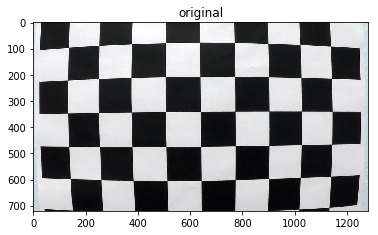

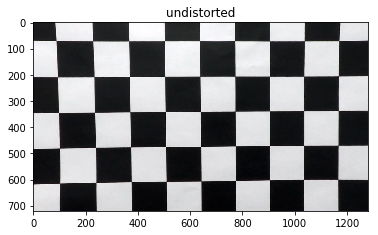

In [18]:
output_dir = "./output_images/"

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# arrays to store object points and image points from each image
objpoints = []
imgpoints = []

images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                   imgpoints,
                                                   gray.shape[::-1],
                                                   None,
                                                   None)
img = cv2.imread(images[1])
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)
plt.title("original")
plt.savefig(output_dir + "camera_calib/original.jpg")
plt.figure()
plt.imshow(undist)
plt.title("undistorted")
plt.savefig(output_dir + "camera_calib/undistorted.jpg")
plt.figure()



### Functions

In [43]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def threshold_x_gradient(img, sobel_x_thresh=(20, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sobel_thresh_min = sobel_x_thresh[0]
    sobel_thresh_max = sobel_x_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(sobel_thresh_min <= scaled_sobel) & (scaled_sobel <= sobel_thresh_max)] = 1
    return sxbinary
    
def threshold_ls_channel(img, l_thresh=(30,255), s_thresh=(145,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    l_thresh_min = l_thresh[0]
    l_thresh_max = l_thresh[1]
    
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
  
    ls_binary = np.zeros_like(s_channel)
    ls_binary[(s_thresh_min <= s_channel) & (s_channel <= s_thresh_max) &
             (l_thresh_min <= l_channel) & (l_channel <= l_thresh_max)] = 1
    return ls_binary
    
def find_lane_pixels(warped):
    img_height = warped.shape[0]
    bottom_half = warped[warped.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    
    out_img = np.dstack((warped, warped, warped))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    margin = 100
    minpix = 83
    
    window_height = np.int(img_height//nwindows)
    
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = img_height - (window+1)*window_height
        win_y_high = img_height - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        inds = np.arange(nonzerox.shape[0])
        good_left_inds = inds[(win_xleft_low <= nonzerox) & ( nonzerox < win_xleft_high) &
                              (win_y_low <= nonzeroy) & (nonzeroy < win_y_high)]
        good_right_inds = inds[(win_xright_low <= nonzerox) & ( nonzerox < win_xright_high) &
                              (win_y_low <= nonzeroy) & (nonzeroy < win_y_high)]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if good_left_inds.shape[0] > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if good_right_inds.shape[0] > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img

def easy_find_lane_pixel(warped):
    margin = 100

    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    inds = np.arange(nonzerox.shape[0])
    left_fitx = nonzeroy**2*l_line.current_fit[0] + nonzeroy*l_line.current_fit[1] + l_line.current_fit[2]
    right_fitx = nonzeroy**2*r_line.current_fit[0] + nonzeroy*r_line.current_fit[1] + r_line.current_fit[2]
    left_lane_inds = inds[np.absolute(left_fitx - nonzerox) <= margin]
    right_lane_inds = inds[np.absolute(right_fitx - nonzerox) <= margin]
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img = np.dstack((warped, warped, warped))
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img



def fit_polynomial(leftx, lefty, rightx, righty, out_img):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, out_img

def fit_polynomial_for_video(leftx, lefty, rightx, righty, out_img):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    l_line.setCurrentFit(left_fit)
    r_line.setCurrentFit(right_fit)
    left_fit = l_line.best_fit
    right_fit = r_line.best_fit
    
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, out_img

def measure_curvature_pixels(leftx, lefty, rightx, righty, out_img):
    
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_eval = (out_img.shape[0]-1)*ym_per_pix
    
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5/abs(2*left_fit[0])
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5/abs(2*right_fit[0])
    
    return left_curverad, right_curverad

def find_position(left_fitx, right_fitx, ploty, out_img):
    img_mid = out_img.shape[1]/2
    lane_mid = (left_fitx[-1] + right_fitx[-1])/2
    return (img_mid - lane_mid)*xm_per_pix
    
    
def mark_lane(left_fitx, right_fitx, ploty, out_img):
    color_warp = np.zeros_like(out_img).astype(np.uint8)
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    return color_warp

### line class

In [59]:
# Define a class to receive the characteristics of each line detection
class Line():
    n = 15
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # the n most recent fit
        self.recent_fit = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #difference in fit coefficients between last and new fits
        self.diffs = [0,0,0]
        
    def setCurrentFit(self, fit):
        if self.current_fit != None:
            self.diffs = self.current_fit - fit
            self.all_diffs.append(np.array(self.diffs))
        self.current_fit = fit
        if len(self.recent_fit) == Line.n:
            self.recent_fit = self.recent_fit[1:]
        self.recent_fit.append(fit)
        self.best_fit = np.mean(self.recent_fit, axis=0)
        
        


### Pipeline on the test images

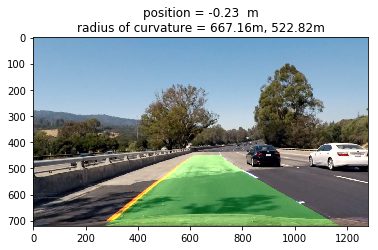

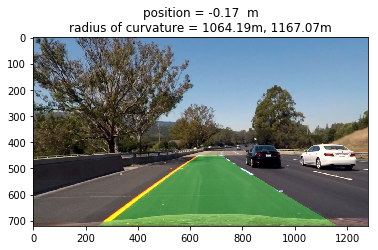

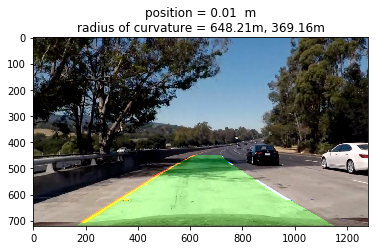

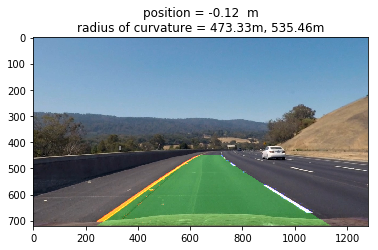

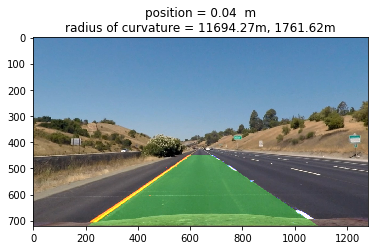

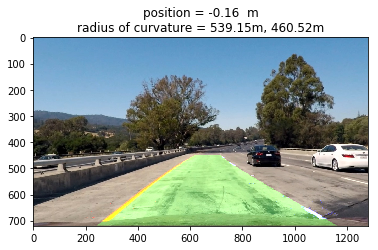

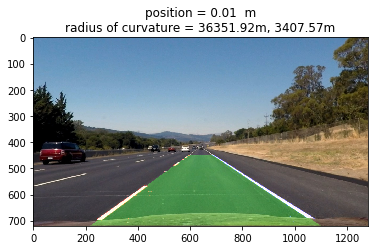

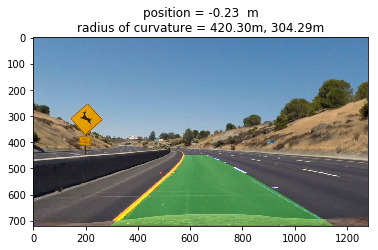

In [67]:
output_dir = "./output_images/"

fnames = glob.glob("test_images/*.jpg")

for i, fname in enumerate(fnames):
    img = plt.imread(fname)
    
    # Undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Sobel x gradient
    sxbinary = threshold_x_gradient(undist)
    
    # hls color masking
    ls_binary = threshold_ls_channel(undist)
   
    # Combine two binary
    combined = np.zeros_like(ls_binary)
    combined[(ls_binary == 1) | (sxbinary == 1)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, ls_binary)) * 255
    
    # prospective transform
    height = undist.shape[0]
    width = undist.shape[1]
    src = np.float32([[596, 450], [690, 450], [1106, 720], [218, 720]])
    dst = np.float32([[width//4, 0], 
                      [width//4*3, 0],
                  [width//4*3, height],
                      [width//4, height]])
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = undist.shape[1::-1]
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    
    # find lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    
    # fit polynomial
    left_fitx, right_fitx, ploty, out_img = fit_polynomial(leftx, lefty, rightx, righty, out_img)
    
    # measure radius of curvature
    left_curverad, right_curverad = measure_curvature_pixels(leftx, lefty, rightx, righty, out_img)

    # find the vichle's position with respect to the center of the lanes
    position = find_position(left_fitx, right_fitx, ploty, out_img)
    title = "position = %.2f  m\nradius of curvature = %.2fm, %.2fm"%(position,left_curverad,right_curverad)
    plt.title(title)
    
    # mark lane
    marked = mark_lane(left_fitx, right_fitx, ploty, out_img)
    
    # plot polinomials 
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    # unwarp
    inv_M = cv2.getPerspectiveTransform(dst, src)
    unwarped_mark = cv2.warpPerspective(marked, inv_M, img_size, flags=cv2.INTER_LINEAR)
    unwarped_lane = cv2.warpPerspective(out_img, inv_M, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undist, 1, unwarped_mark, 0.3, 0)
    result = cv2.addWeighted(result, 1, unwarped_lane, 0.5, 0)
    plt.imshow(result)
#     plt.figure()
#     plt.imshow(undist)
    
# Save images
#     plt.imsave(output_dir + "undist/" + fname[12:], undist)
#     plt.imsave(output_dir + "sobel_s_channel_color/" + fname[12:], color_binary)
#     plt.imsave(output_dir + "sobel_s_channel/" + fname[12:], combined, cmap="gray")
#     plt.imsave(output_dir + "undist_warped/" + fname[12:], warped)
#     plt.imsave(output_dir + "threshold_warped/" + fname[12:], warped, cmap="gray")
#     plt.imsave(output_dir + "lane_pixel/" + fname[12:], out_img)
#     plt.savefig(output_dir + "marked_lane/" + fname[12:])
#     plt.savefig(output_dir + "lane_pixel/" + fname[12:])
    plt.figure()



In [61]:
# import library for video processing
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [62]:
def process_image(image):
    
    # Undistort the image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Sobel x gradient
    sxbinary = threshold_x_gradient(undist)
    
    # hls color masking
    ls_binary = threshold_ls_channel(undist)
   
    # Combine two binary
    combined = np.zeros_like(ls_binary)
    combined[(ls_binary == 1) | (sxbinary == 1)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, ls_binary)) * 255
    
    # prospective transform
    height = undist.shape[0]
    width = undist.shape[1]
    src = np.float32([[596, 450], [690, 450], [1106, 720], [218, 720]])
    dst = np.float32([[width//4, 0], 
                      [width//4*3, 0],
                      [width//4*3, height],
                      [width//4, height]])
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = undist.shape[1::-1]
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    
    
    # find lane pixels
    if l_line.detected:
        leftx, lefty, rightx, righty, out_img = easy_find_lane_pixel(warped)
    else:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    
    # fit polynomial
    left_fitx, right_fitx, ploty, out_img = fit_polynomial_for_video(leftx, lefty, rightx, righty, out_img)
    l_line.detected = True
    r_line.detected = True
    
    # measure radius of curvature
    left_curverad, right_curverad = measure_curvature_pixels(leftx, lefty, rightx, righty, out_img)
    left_radius_str = 'left curvature radius: %.2fm' %(left_curverad)
    right_radius_str = 'right curvature radius: %.2fm'%(right_curverad)
    cv2.putText(undist, left_radius_str,(10,70), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),2,cv2.LINE_AA)
    cv2.putText(undist, right_radius_str,(10,110), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),2,cv2.LINE_AA)

    # find the vichle's position with respect to the center of the lanes
    position = find_position(left_fitx, right_fitx, ploty, out_img)
    position_str = 'position: %.2fm'%(position)
    cv2.putText(undist, position_str,(10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),2,cv2.LINE_AA)

    # mark lane
    marked_lane = mark_lane(left_fitx, right_fitx, ploty, out_img)
    
    # unwarp
    inv_M = cv2.getPerspectiveTransform(dst, src)
    unwarped_mark = cv2.warpPerspective(marked_lane, inv_M, img_size, flags=cv2.INTER_LINEAR)
    unwarped_lane = cv2.warpPerspective(out_img, inv_M, img_size, flags=cv2.INTER_LINEAR)

    # overlay marked lane on the original image
    result = cv2.addWeighted(undist, 1, unwarped_mark, 0.3, 0)
    result = cv2.addWeighted(result, 1, unwarped_lane, 0.5, 0)
    
    return result

### Process Video

In [63]:
l_line = Line()
r_line = Line()
output = 'output_videos/marked_project_video.mp4'
video_input = "project_video.mp4"
# clip1 = VideoFileClip(video_input).subclip(2,5)
# clip1 = VideoFileClip(video_input).subclip(19,25)
clip1 = VideoFileClip(video_input)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/marked_project_video.mp4
[MoviePy] Writing video output_videos/marked_project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.

100%|█████████▉| 1260/1261 [05:30<00:00,  3.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/marked_project_video.mp4 

CPU times: user 3min 14s, sys: 3.22 s, total: 3min 17s
Wall time: 5min 33s


In [64]:
output = 'output_videos/marked_project_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [10]:
l_line = Line()
r_line = Line()
challenge_output = 'output_videos/marked_challenge_video.mp4'
video_input = "challenge_video.mp4"
clip1 = VideoFileClip(video_input).subclip(0,1)
# clip1 = VideoFileClip(video_input).subclip(5,10)
# clip1 = VideoFileClip(video_input)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/marked_challenge_video.mp4
[MoviePy] Writing video output_videos/marked_challenge_video.mp4



100%|██████████| 30/30 [00:07<00:00,  6.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/marked_challenge_video.mp4 

CPU times: user 3.91 s, sys: 450 ms, total: 4.36 s
Wall time: 10.1 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))